### **<font color='teal'> 1. Sourcing and Loading the Data </font>**

##### **<font color='teal'> 1.1. Importing Libraries </font>**

In [429]:
#!pip install tensorflow

In [430]:
# Importing and checking the version of Tensor Flow.
import tensorflow as tf
tf.version.VERSION

'2.14.0'

In [2]:
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import pickle
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from scipy import ndimage
import cv2  # OpenCV for flipping and scaling

#from jupyterthemes import jtplot
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 

c:\Users\sabhe\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


##### **<font color='teal'> 1.2. Loading the data </font>**

In [3]:
# Reading and checking the CSV file
df=pd.read_csv("../data/emotion.csv")

### **<font color='teal'> 2. Exploring the Data </font>**

##### **<font color='teal'> 2.1. Renaming Column Name </font>**

In [4]:
# 'pixels' column has space in the csv file so we are removing that space .
df = df.rename(columns={' pixels': 'pixels'})

##### **<font color='teal'> 2.2. Converting pixel values in string format to array format </font>**

In [5]:
# function to convert pixel values in string format to array format
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [6]:
df['pixels'] = df['pixels'].apply(lambda x: string2array(x))

In [7]:
type(df['pixels'][2])

numpy.ndarray

In [8]:
df['pixels'][2].shape

(48, 48, 1)

##### **<font color='teal'> 3.1. Creating Image Augmentation Function </font>**

In [9]:
def image_augmentation(augmentation_num,Images,emotion_label):
    # Define the number of augmented images you want per input image
    num_augmentations = augmentation_num

    # Create an array to store augmented images
    augmented_images = []

    # Loop through each input image
    for image in Images:
        # Ensure that each image has a consistent shape (48, 48)
        image = image.reshape(48, 48)

        for _ in range(num_augmentations):
            # Rotate the image by a random angle between -20 and 20 degrees
            rotated_image = ndimage.rotate(image, np.random.uniform(-20, 20), reshape=False)

            # Flip the image horizontally (left to right) with a 50% probability
            if np.random.choice([True, False]):
                rotated_image = np.fliplr(rotated_image)

            # Scale the image by a random factor between 0.8 and 1.2
            scale_factor = np.random.uniform(0.8, 1.2)
            scaled_image = cv2.resize(rotated_image, (48, 48), interpolation=cv2.INTER_LINEAR)

            # Append the augmented image to the list
            augmented_images.append(scaled_image)

    # Convert the list of augmented images back to a NumPy array
    augmented_images = np.array(augmented_images)
    # Flatten each image in 'augmented_images' to a 1D array
    flattened_images = [image.flatten() for image in augmented_images]

   

    # Create a DataFrame for the augmented data
    augmented_df = pd.DataFrame({'emotion': emotion_label, 'pixels': flattened_images})
    return augmented_df



**<font color='blue'> Data Augmentation for Disgust Images </font>**

In [10]:
disgust_images=df[df['emotion']==1]
augmented_disgust=image_augmentation(1,disgust_images['pixels'],1)
df = pd.concat([df, augmented_disgust], ignore_index=True)


In [11]:
emotions_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad'}

a = df['emotion'].value_counts().rename('Count')
b = (df['emotion'].value_counts(normalize=True) * 100).rename('Distribution')

temp = pd.concat([a, b], axis=1)
temp.index = [emotions_labels[i] for i in temp.index]
temp

,Count,Distribution
Happy,8989,35.791360
Fear,6077,24.196695
Angry,4953,19.721282
Sad,4002,15.934700
Disgust,1094,4.355963


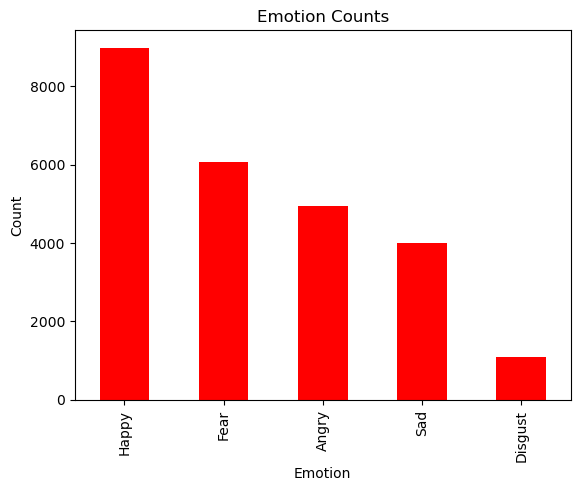

In [12]:
temp.plot(y='Count', kind='bar', legend=False,color='red')  # Plot the 'Count' column as a bar chart

# Set the title and labels
plt.title('Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Display the plot
plt.show()

**<font color='blue'> Now, the dataset is well-balanced, ensuring that each class has a nearly equal number of samples. </font>**

In [450]:
df

,emotion,pixels
0,0,"[[[70.0], [80.0], [82.0], [72.0], [58.0], [58...."
1,0,"[[[151.0], [150.0], [147.0], [155.0], [148.0],..."
2,2,"[[[24.0], [32.0], [36.0], [30.0], [32.0], [23...."
3,2,"[[[20.0], [17.0], [19.0], [21.0], [25.0], [38...."
4,3,"[[[77.0], [78.0], [79.0], [79.0], [78.0], [75...."
...,...,...
41723,0,"[0.0, 157.48335, 153.27704, 148.79697, 148.433..."
41724,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
41725,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
41726,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
